In [1]:
# Importing Packages
import matplotlib.pyplot as plt
import random

import pandas as pd
from itertools import takewhile
import plotly.graph_objects as go
import plotly.express as px
import base64
import numpy as np
import glob
import xarray as xr
from numpy import loadtxt

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from fig_mods.nextstep import areagrid

In [2]:
ds_flux = xr.open_dataset("data/flux_data.nc")

## Set the longitude and latitude to only include the UK;

min_lon = -12
min_lat = 48
max_lon = 5 
max_lat = 62  

ds_flux = ds_flux.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
#ds_flux

In [3]:
lat = np.arange(48.169, 61.975, 0.234)
lon = np.arange(-11.66, 4.884, 0.352)
area = areagrid(lat, lon)

In [4]:
## Create a function to produce a mean flux reading for each year;

def weighted_temporal_mean(ds, var):

    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")
    
    return obs_sum / ones_out

In [5]:
Intem_new_year = weighted_temporal_mean(ds_flux, "flux_prior")
Intem2012 = Intem_new_year[dict(time=0)] * area
Intem2013 = Intem_new_year[dict(time=1)] * area
Intem2014 = Intem_new_year[dict(time=2)] * area
Intem2015 = Intem_new_year[dict(time=3)] * area
#Intem2012.values.std()

In [6]:
def read_invent_ch4(year, species):
    import pandas as pd
    from itertools import takewhile
    import plotly.graph_objects as go
    import base64
    import numpy as np
    import glob
    import xarray as xr
    
    csv = glob.glob(f"data/ch4-ukghg-{species}_EUROPE_{year}.nc")
    
    flux = xr.open_dataset(csv[0])
    
    min_lon = -12
    min_lat = 48
    max_lon = 5 
    max_lat = 62 
    
    cropped_ds = flux.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
    
    cropped_ds = cropped_ds * area
    
    return cropped_ds

In [7]:
def MC_intem(year, species, nvalue):
    
    MCtest = pd.DataFrame()
    
    x = read_invent_ch4(year, species)
    y = read_invent_ch4(year, "total")
    
    fract = x.flux / y.flux
    test = fract.reindex_like(Intem2012, method='nearest', tolerance=0.01)
    test1 = test.fillna(0)

    if year == "2012":
        data = Intem2012
    elif year == "2013":
        data = Intem2013
    elif year == "2014":
        data = Intem2014
    elif year == "2015":
        data = Intem2015
    
    test1 = test.fillna(0)
    
    for i in range(nvalue):
        a = np.random.normal(data * test1, 0.1 * Intem2012.values, size=(60, 48))
        b = {year + species: [a.sum()]}
        c = pd.DataFrame(b)
    
        MCtest = pd.concat([MCtest, c])

    #MCtest.mean()

    return MCtest

In [8]:
years = ["2012", "2013", "2014", "2015"]

agri = pd.DataFrame()

for data in (years):
    a = MC_intem(data, "agric", nvalue=100)
    b = a.rename(columns={"col1" : data})
    
    agri = pd.concat([agri, b], axis=1)
    
agri

,2012agric,2013agric,2014agric,2015agric
0,1838.406500,1903.570673,1866.484419,1885.001839
0,1844.334697,1918.815209,1904.108258,1948.698469
0,1825.141581,1857.145223,1891.006758,1945.664404
0,1849.533319,1866.899898,1912.633059,1977.991655
0,1890.946563,1840.420570,1906.795044,1981.399972
...,...,...,...,...
0,1816.370018,1827.504983,1967.772154,1922.111663
0,1848.253446,1825.908067,1985.801370,1947.387925
0,1852.815822,1829.359456,1895.957082,1923.817719
0,1884.037452,1895.383566,1913.709834,1939.073531


In [9]:
MC_intem("2012", "agric", 100)

,2012agric
0,1795.872826
0,1887.747205
0,1778.391620
0,1882.183643
0,1849.601742
...,...
0,1811.968947
0,1805.857242
0,1833.489752
0,1870.527173


In [2]:
import xarray as xr

In [10]:
ch4 = xr.open_dataset("/Users/jz18106//Downloads/ch4-ukghg_2000/ch4-ukghg-waste_EUROPE_2000.nc")

In [11]:
ch4

<xarray.Dataset>
Dimensions:  (lat: 293, lon: 391, time: 1)
Coordinates:
  * lat      (lat) float32 10.73 10.96 11.2 11.43 ... 78.36 78.59 78.82 79.06
  * lon      (lon) float32 -97.9 -97.55 -97.2 -96.84 ... 38.32 38.68 39.03 39.38
  * time     (time) datetime64[ns] 2000-01-01
Data variables:
    flux     (lat, lon, time) float32 ...
Attributes:
    Processed by:   wz22079@bristol.ac.uk
    Processed on:   2022-10-19 14:16:36.205106+00:00
    title:          UKGHG sectors regridded to EUROPE domain
    UKGHG sectors:  waste

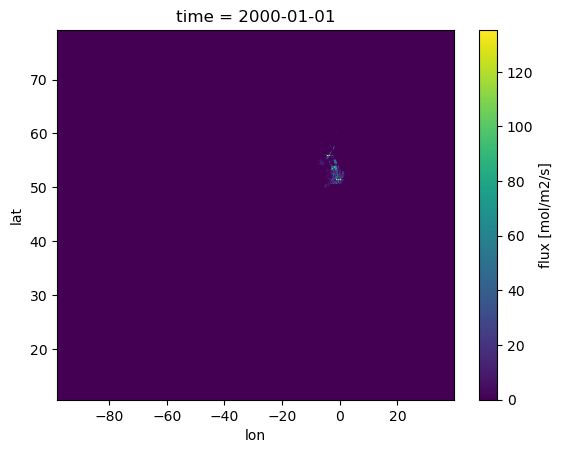

In [12]:
ch4.flux.plot()